# Preparing system

In [113]:
import setGPU

In [114]:
# limit GPU usage
import sys
import tensorflow as tf
gpuFraction = 0.4
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpuFraction)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
import keras
from keras import backend as K
K.set_session(sess)
print('using gpu memory fraction: '+str(gpuFraction))

using gpu memory fraction: 0.4


In [115]:
%matplotlib inline

In [116]:
# imports
import h5py
import glob
import numpy as np

In [117]:
# need afs password to read from eos
import os
import getpass
os.system("echo %s| kinit" %getpass.getpass())

········


0

# Import files

In [118]:
# open the new dataset
fileIn = h5py.File("ZtoNuNu_lepFilter_13TeV_JetImage_1.h5")
#delphesPt = fileIn.get("jetSmearedDelphes")
print(list(fileIn.keys()))

['jetECALImages', 'jetHCALImages', 'jetMomenta', 'jetTrkImages', 'rawJetMomenta', 'trkList']


In [156]:
# assign names
truth = fileIn.get("jetMomenta")
raw = fileIn.get("rawJetMomenta")
eCal = fileIn.get("jetECALImages")
hCal = fileIn.get("jetHCALImages")
track = fileIn.get("jetTrkImages")
trkList = fileIn.get("trkList")

# Prepare train and test samples



In [153]:
from sklearn.preprocessing import MinMaxScaler
# normalize raw inputs and outputs between 0 and 1
scaler = MinMaxScaler()
print(scaler.fit(raw))
maxVal = scaler.data_max_
minVal = scaler.data_min_
raw = (raw-minVal)/(maxVal-minVal)
#truth = (truth-minVal)/(maxVal-minVal)

MinMaxScaler(copy=True, feature_range=(0, 1))


In [157]:
np.average(truth)
truth = truth[:,0]
truth = np.reshape(truth, (truth.shape[0], 1))
np.average(truth)

34.453424491596564

In [158]:
# split sets
iSplit = int(0.7*truth.shape[0])
eCal_image_train = eCal[:iSplit, :, :]
eCal_image_test = eCal[iSplit:, :, :]
hCal_image_train = hCal[:iSplit, :, :]
hCal_image_test = hCal[iSplit:, :, :]
trk_image_train = track[:iSplit, :, :]
trk_image_test = track[iSplit:, :, :]
lst_train = trkList[:iSplit, :, :]
lst_test = trkList[iSplit:,:,:]
raw_train = raw[:iSplit, :]
raw_test = raw[iSplit:, :]
y_train = truth[:iSplit, :]
y_test = truth[iSplit:, :]

In [20]:
# Reshape eCal
eCal_image_test = np.reshape(eCal_image_test, (eCal_image_test.shape[0], eCal_image_test.shape[1],
                                         eCal_image_test.shape[2], 1))
eCal_image_train = np.reshape(eCal_image_train, (eCal_image_train.shape[0], eCal_image_train.shape[1],
                                           eCal_image_train.shape[2], 1))

In [21]:
# Reshape hCal
hCal_image_test = np.reshape(hCal_image_test, (hCal_image_test.shape[0], hCal_image_test.shape[1],
                                         hCal_image_test.shape[2], 1))
hCal_image_train = np.reshape(hCal_image_train, (hCal_image_train.shape[0], hCal_image_train.shape[1],
                                           hCal_image_train.shape[2], 1))

In [22]:
# Reshape trackimg
trk_image_test = np.reshape(trk_image_test, (trk_image_test.shape[0], trk_image_test.shape[1],
                                         trk_image_test.shape[2], 1))
trk_image_train = np.reshape(trk_image_train, (trk_image_train.shape[0], trk_image_train.shape[1],
                                           trk_image_train.shape[2], 1))

In [23]:
# Reshape track list
lst_test = np.reshape(lst_test, (lst_test.shape[0], lst_test.shape[1],
                                         lst_test.shape[2], 1))
lst_train = np.reshape(lst_train, (lst_train.shape[0], lst_train.shape[1],
                                           lst_train.shape[2], 1))

# build the model

In [24]:
# keras imports
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, Conv1D, Dropout, Flatten, Concatenate, Reshape, BatchNormalization
from keras.layers import MaxPooling2D, MaxPooling3D, GRU
from keras.utils import plot_model
from keras import regularizers
from keras import backend as K
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [25]:
batch_size = 128

In [26]:
# Inputs
InputRaw = Input(shape=(4,))
inputeCal = Input(shape=(25,25,1))
inputhCal = Input(shape=(5,5,1))
inputTrk = Input(shape=(25,25,1))
inputList = Input(shape=(50,3,1))

In [27]:
# Raw
x2 = BatchNormalization()(InputRaw)

In [28]:
# eCal
e = BatchNormalization()(inputeCal)
e = Conv2D(30, kernel_size=(3, 3), activation='selu', data_format="channels_last", strides=(3, 3), input_shape=(25,25,1))(e)
e = Dropout(0.25)(e)
e = Conv2D(20, kernel_size=(3,3), strides=(3,3), activation='selu')(e)
e = Dropout(0.25)(e)
e = Flatten()(e)

# hCal
h = BatchNormalization()(inputhCal)
h = Conv2D(20, kernel_size=(3, 3), data_format="channels_last", strides=(3, 3), activation='selu', input_shape=(5,5,1))(h)
h = Dropout(0.25)(h)
h = Flatten()(h)

In [29]:
# track image
t = BatchNormalization()(inputTrk)
t = Conv2D(30, kernel_size=(3, 3), data_format="channels_last", strides=(3, 3), activation='selu', input_shape=(25,25,1))(t)
t = Dropout(0.25)(t)
t = Conv2D(20, kernel_size=(3,3), strides=(3, 3), activation='selu')(t)
t = Dropout(0.25)(t)
t = Flatten()(t)

In [30]:
# tracklist conv1d
tl1 = BatchNormalization()(inputList)
tl1 = Reshape((50,3))(tl1)
tl1 = Conv1D(3, kernel_size=(3), strides=(3),activation='selu',padding='same')(tl1)
tl1 = Dropout(0.25)(tl1)
tl1 = Flatten()(tl1)

In [31]:
# tracklist gRU
tlg = BatchNormalization()(inputList)
print(tlg.shape)
tlg = Reshape((50,3))(tlg)
tlg = GRU(3, activation='selu', recurrent_activation='hard_sigmoid')(tlg)

(?, 50, 3, 1)


In [32]:
# image output
denseImg = Concatenate(axis=1)([x2, e, h, t])
denseImg = Dense(20, activation='selu')(denseImg)
denseImg = Dropout(0.25)(denseImg)
denseImg = Dense(10, activation='selu')(denseImg)
denseImg = Dropout(0.25)(denseImg)
outputImg = Dense(1, activation='linear')(denseImg)

In [33]:
# conv1d output
denseConv = Concatenate(axis=1)([x2, e, h, tl1])
denseConv = Dense(20, activation='selu')(denseConv)
denseConv = Dropout(0.25)(denseConv)
denseConv = Dense(10, activation='selu')(denseConv)
denseConv = Dropout(0.25)(denseConv)
outputConv = Dense(1, activation='linear')(denseConv)

In [34]:
# GRU output
denseGRU = Concatenate(axis=1)([x2, e, h, tlg])
denseGRU = Dense(20, activation='selu')(denseGRU)
denseGRU = Dropout(0.25)(denseGRU)
denseGRU = Dense(10, activation='selu')(denseGRU)
denseGRU = Dropout(0.25)(denseGRU)
outputGRU = Dense(1, activation='linear')(denseGRU)

In [35]:
# Image model
modelImg = Model(inputs=[InputRaw,inputeCal, inputhCal, inputTrk, inputList], outputs=outputImg)

In [36]:
# Conv1d model
modelConv = Model(inputs=[InputRaw,inputeCal, inputhCal, inputTrk, inputList], outputs=outputConv)

In [37]:
# GRU model
modelGRU = Model(inputs=[InputRaw,inputeCal, inputhCal, inputTrk, inputList], outputs=outputGRU)

In [38]:
modelImg.compile(loss='mse', optimizer='adam')
modelImg.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 25, 25, 1)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 25, 25, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 25, 25, 1)    4           input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 25, 25, 1)    4           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (

In [39]:
modelConv.compile(loss='mse', optimizer='adam')
modelConv.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 25, 25, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 25, 25, 1)    4           input_2[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 50, 3, 1)     0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 30)     300         batch_normalization_2[0][0]      
__________________________________________________________________________________________________
input_3 (I

In [40]:
modelGRU.compile(loss='mse', optimizer='adam')
modelGRU.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 25, 25, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 25, 25, 1)    4           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 30)     300         batch_normalization_2[0][0]      
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 5, 5, 1)      0                                            
__________________________________________________________________________________________________
dropout_1 

In [41]:
# train image model 
historyImg = modelImg.fit([raw_train, eCal_image_train, hCal_image_train, trk_image_train, lst_train], y_train, epochs=100, batch_size=batch_size, verbose = 1,
                validation_data=([raw_test, eCal_image_test, hCal_image_test, trk_image_test, lst_test], y_test),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 111946 samples, validate on 47977 samples
Epoch 1/100
111946/111946 [==============================] - 9s 77us/step - loss: 0.0549 - val_loss: 2.2284e-04
Epoch 2/100
111946/111946 [==============================] - 7s 62us/step - loss: 0.0021 - val_loss: 1.5983e-04
Epoch 3/100
111946/111946 [==============================] - 7s 60us/step - loss: 8.3277e-04 - val_loss: 1.4400e-04

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/100
111946/111946 [==============================] - 7s 61us/step - loss: 5.9155e-04 - val_loss: 1.2984e-04
Epoch 5/100
111946/111946 [==============================] - 7s 62us/step - loss: 5.5082e-04 - val_loss: 1.2575e-04

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 6/100
111946/111946 [==============================] - 7s 61us/step - loss: 5.1226e-04 - val_loss: 1.2395e-04
Epoch 7/100
111946/111946 [==============================] - 7s 61us/step - loss: 5.0701e-04 - va

In [42]:
# Train conv1d model
historyConv = modelConv.fit([raw_train, eCal_image_train, hCal_image_train, trk_image_train, lst_train], y_train, epochs=100, batch_size=batch_size, verbose = 1,
                validation_data=([raw_test, eCal_image_test, hCal_image_test, trk_image_test, lst_test], y_test),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 111946 samples, validate on 47977 samples
Epoch 1/100
111946/111946 [==============================] - 7s 65us/step - loss: 0.0737 - val_loss: 2.9661e-04
Epoch 2/100
111946/111946 [==============================] - 6s 57us/step - loss: 0.0029 - val_loss: 1.8551e-04
Epoch 3/100
111946/111946 [==============================] - 6s 57us/step - loss: 0.0012 - val_loss: 1.5876e-04
Epoch 4/100
111946/111946 [==============================] - 6s 57us/step - loss: 6.7827e-04 - val_loss: 1.3486e-04

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/100
111946/111946 [==============================] - 6s 58us/step - loss: 5.1771e-04 - val_loss: 1.2687e-04
Epoch 6/100
111946/111946 [==============================] - 6s 58us/step - loss: 4.9051e-04 - val_loss: 1.1908e-04

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 7/100
111946/111946 [==============================] - 6s 57us/step - loss: 4.7488e-04 - val_lo

In [43]:
# Train GRU model
historyGRU = modelGRU.fit([raw_train, eCal_image_train, hCal_image_train, trk_image_train, lst_train], y_train, epochs=100, batch_size=batch_size, verbose = 1,
                validation_data=([raw_test, eCal_image_test, hCal_image_test, trk_image_test, lst_test], y_test),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 111946 samples, validate on 47977 samples
Epoch 1/100
111946/111946 [==============================] - 39s 345us/step - loss: 0.0128 - val_loss: 1.2862e-04
Epoch 2/100
111946/111946 [==============================] - 38s 336us/step - loss: 6.9821e-04 - val_loss: 1.0008e-04
Epoch 3/100
111946/111946 [==============================] - 37s 335us/step - loss: 3.6567e-04 - val_loss: 8.6413e-05

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/100
111946/111946 [==============================] - 37s 333us/step - loss: 2.8476e-04 - val_loss: 9.4904e-05
Epoch 5/100
111946/111946 [==============================] - 37s 334us/step - loss: 2.8074e-04 - val_loss: 1.0124e-04

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 6/100
111946/111946 [==============================] - 37s 334us/step - loss: 2.7280e-04 - val_loss: 9.2139e-05
Epoch 7/100
111946/111946 [==============================] - 38s 335us/step - los

# Analysis

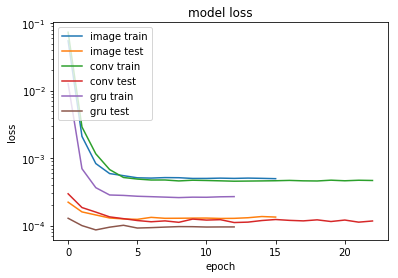

In [44]:
# plot training histories
plt.plot(historyImg.history['loss'])
plt.plot(historyImg.history['val_loss'])
plt.plot(historyConv.history['loss'])
plt.plot(historyConv.history['val_loss'])
plt.plot(historyGRU.history['loss'])
plt.plot(historyGRU.history['val_loss'])
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['image train', 'image test', 'conv train', 'conv test','gru train','gru test'], loc='upper left')
plt.show()
#

In [45]:
# image prediction
ImgPredict = modelImg.predict([raw_test, eCal_image_test, hCal_image_test, trk_image_test, lst_test])
ImgPredict = np.reshape(ImgPredict, (ImgPredict.shape[0],))

In [46]:
# conv1d prediction
ConvPredict = modelConv.predict([raw_test, eCal_image_test, hCal_image_test, trk_image_test, lst_test])
ConvPredict = np.reshape(ConvPredict, (ConvPredict.shape[0],))

In [47]:
# GRU prediction
GRUPredict = modelGRU.predict([raw_test, eCal_image_test, hCal_image_test, trk_image_test, lst_test])
GRUPredict = np.reshape(GRUPredict, (GRUPredict.shape[0],))

In [142]:
#put pT back in its range
pTraw = minVal[0] + raw_test[:,0]*(maxVal[0]-minVal[0])
pTreco = minVal[0] + np.reshape(y_test, (y_test.shape[0],))*(maxVal[0]-minVal[0])
ImgPredict = minVal[0] + ImgPredict*(maxVal[0]-minVal[0])
ConvPredict = minVal[0] + ConvPredict*(maxVal[0]-minVal[0])
GRUPredict = minVal[0] + GRUPredict*(maxVal[0]-minVal[0])

In [143]:
ImgPredict.astype(int)
GRUPredict.astype(int)

[29779.896 27148.213 21058.697 ... 31231.    21210.059 23372.648]
[27540.908 22940.402 19244.863 ... 28439.504 17578.723 19026.   ]
[32521.053 27182.297 14696.249 ... 36278.254 10786.595 18166.186]


array([32521, 27182, 14696, ..., 36278, 10786, 18166])

In [191]:
y_test = y_test[:,0]

IndexError: too many indices for array

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


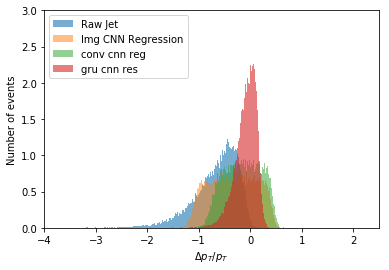

RAW MEAN: -0.670721
RAW RMS: 0.447598
-------------------
img CNN MEAN: -0.339778
img CNN RMS: 0.441940
-------------------
conv CNN MEAN: -0.150253
conv CNN RMS: 0.350974
-------------------
gru CNN MEAN: -0.085971
gru CNN RMS: 0.208824


In [56]:
# plot resolutions
plt.xlim(-4., 2.5)
plt.ylim(0.,3.)
resRaw = np.nan_to_num((pTreco-pTraw)/pTreco)
ImgresCNN = np.nan_to_num((pTreco-ImgPredict)/pTreco)
ConvresCNN = np.nan_to_num((pTreco-ConvPredict)/pTreco)
GRUresCNN = np.nan_to_num((pTreco-GRUPredict)/pTreco)
plt.hist(resRaw, bins = 500, normed=1, alpha = 0.6)
plt.hist(ImgresCNN, bins = 500, normed=1, alpha = 0.5)
plt.hist(ConvresCNN, bins = 500, normed=1, alpha = 0.5)
plt.hist(GRUresCNN, bins = 500, normed=1, alpha = 0.6)
plt.ylabel('Number of events')
plt.xlabel('$\Delta p_T/p_T$')
plt.legend(['Raw Jet','Img CNN Regression','conv cnn reg','gru cnn res'], loc='upper left')
plt.show()


from scipy.stats import norm
(mu, sigma) = norm.fit(resRaw)
print("RAW MEAN: %f" %mu)
print("RAW RMS: %f" %sigma)
print("-------------------")
(mu, sigma) = norm.fit(ImgresCNN)
print("img CNN MEAN: %f" %mu)
print("img CNN RMS: %f" %sigma)
print("-------------------")
(mu, sigma) = norm.fit(ConvresCNN)
print("conv CNN MEAN: %f" %mu)
print("conv CNN RMS: %f" %sigma)
print("-------------------")
(mu, sigma) = norm.fit(GRUresCNN)
print("gru CNN MEAN: %f" %mu)
print("gru CNN RMS: %f" %sigma)

[54.95016861 35.20664597 18.18580055 ... 53.33313751 16.09989166
 17.94204521]


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


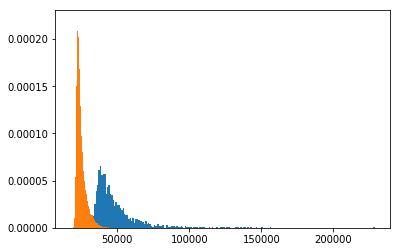

In [187]:
print(y_test)
a = y_test > 80
b = y_test < 80
plt.hist(ImgPredict[a], bins=200, normed=1)
plt.hist(ImgPredict[b], bins=200, normed=1)
plt.show()

In [190]:
threshold1 = 35000
myTestArray_sig_Img = ImgPredict[a] > threshold1
myTestArray_bkg_Img = ImgPredict[b] > threshold1
print("Img True Positive Rate %f" %(myTestArray_sig_Img.sum()/float((a).sum())))
print("Img False Positive Rate %f" %(myTestArray_bkg_Img.sum()/float((b).sum())))

Img True Positive Rate 0.960174
Img False Positive Rate 0.018287


[ True  True  True ...  True  True  True]


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


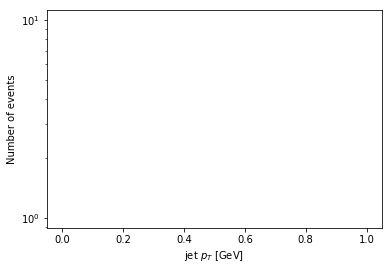

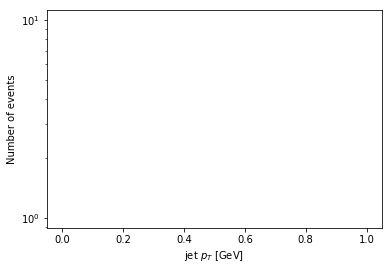

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


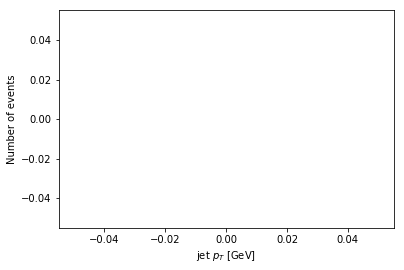

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 

In [182]:
# denominator: all jets 
alljet_pt = raw_test[:,0]
alljet_pt = alljet_pt.reshape((len(alljet_pt),1))
goodjets = ImgPredict>threshold1
print(goodjets)
goodjet_pt = alljet_pt[goodjets]
countsAllJets, bins, bars = plt.hist(alljet_pt, bins=200, range=(0.,1))
plt.xlabel("jet $p_T$ [GeV]")
plt.ylabel("Number of events")
plt.yscale('log')
plt.show()
# numerator: only jets estimated to be > 40 GeV (score ) 
countsGoodJets, bins, bars = plt.hist(goodjet_pt, bins=200, range=(0.,1))
plt.xlabel("jet $p_T$ [GeV]")
plt.ylabel("Number of events")
plt.yscale('log')
plt.show()
# recenter the bins
half_bin_width = (bins[1]-bins[0])/2.
bins = bins - half_bin_width
# rescale 
bins = minVal[0] + bins*(maxVal[0]-minVal[0])
bins = bins[1:]
# plot the ratio
ratio = countsGoodJets/countsAllJets
plt.plot(bins[0:10], ratio[0:10])
plt.xlabel("jet $p_T$ [GeV]")
plt.ylabel("Number of events")
plt.show()
print(countsGoodJets)
print(countsAllJets)